In [145]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.isotonic import IsotonicRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.integration import CatBoostPruningCallback
from optuna.integration import XGBoostPruningCallback

# Import Loan Dataset

In [4]:
# import dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv") # The testing dataset does not contain the target variable "loan_status"

In [5]:
# info on training dataset
print(df_train.columns, '\n')
print(df_train.shape)
display(df_train.describe())

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object') 

(58645, 13)


,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
# info on testing dataset
print(df_test.columns, '\n')
print(df_test.shape)
display(df_test.describe())

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object') 

(39098, 12)


,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


# Cleaning Dataset

## Checking for Nulls

In [9]:
df_train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [10]:
df_test.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## Remove unnecessary features

In [12]:
# Drop the 'id' column
df_train.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)

In [13]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# EDA: Exploratory Data Analysis

Fields in the dataset:
- `person_age`
    - The age of the borrower
- `person_income`
    - The annual income of the borrower
- `person_home_ownership`
    - The home ownership status of the borrower
- `person_emp_length`
    - How long (in years) the borrower has been in employment
- `loan_intent`
    - The borrower's intended use of the loan
- `loan_grade`
    - The loan grade, measuring the loan default rate
- `loan_amnt`
    - Amount borrowed by the borrower
- `loan_int_rate`
    - Loan interest rate
- `loan_percent_income`
    - The ratio between `loan_amnt` and `person_income`
- `cb_person_default_on_file`
    - The borrower's prior default status
- `cb_person_cred_hist_length`
    - The length of the borrower's credit history
- `loan_status`
    - This is the target variable
    - `0` indicates non-default; `1` indicates default

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

EDA will be performed in Tableau
- Refer to https://www.kaggle.com/code/satyaprakashshukl/loan-approval-prediction/notebook, to give ideas on what charts to be generated

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [17]:
# Check the data type of each field
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [18]:
# Check for data imbalance
df_train['loan_status'].value_counts()

0    50295
1     8350
Name: loan_status, dtype: int64

The dataset is very imbalanced! This will be addressed later by applying class weights and threshold tuning.

# Feature Transformation

- One-hot-encoding -> Nomical categorical features
    - person_home_ownership, loan_intent, cb_person_default_on_file
- Ordinal Encoder -> Ordinal categorical features
    - loan_grade
- Robust Scaling -> Numerical features
    - person_age, person_income, person_emp_length, loan_amnt, loan_int_rate, loan_percent_income, cb_person_cred_hist_length
- Target variable
    - loan_status

In [22]:
df_train_trans = df_train.copy()
df_test_trans = df_test.copy()

In [23]:
def robust_scaling(df_train, df_test, feature_list):
    '''
    Use Robust Scaler to scale numerical features
    
    Input
    -----
    - df: DataFrame that stores all features
    - feature_list: List of features in df being transformed
    
    Output
    ------
    A subset of the orignial df, containing only the transformed features
    '''
    
    scaler = RobustScaler()
    scaled_df_train = scaler.fit_transform(df_train[feature_list])
    scaled_df_test = scaler.transform(df_test[feature_list])
    
    return scaled_df_train, scaled_df_test

In [24]:
# Perform robust scaling on numerical features
num_features = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'
]

df_train_trans[num_features], df_test_trans[num_features] = robust_scaling(df_train, df_test, num_features)

In [25]:
# Perform one-hot encoding on nominal cateogrical features
nom_cat_features = [
    'person_home_ownership', 'loan_intent', 'cb_person_default_on_file'
]

df_train_trans = pd.get_dummies(df_train_trans, columns=nom_cat_features)
df_test_trans = pd.get_dummies(df_test_trans, columns=nom_cat_features)

In [26]:
# Perform ordinal encoding on ordinal cateogrical features
ord_cat_features = [
    'loan_grade'
]

ord_encoder = OrdinalEncoder(categories=[
    ['A', 'B', 'C', 'D', 'E', 'F', 'G']
])

df_train_trans[ord_cat_features] = ord_encoder.fit_transform(df_train[ord_cat_features])
df_test_trans[ord_cat_features] = ord_encoder.transform(df_test[ord_cat_features])

In [27]:
# Separate features and target variables
X_train, y_train = df_train_trans.drop('loan_status', axis=1), df_train_trans['loan_status']
X_test = df_test_trans

# Modelling

Random side note:
- `StratifiedKFold` function
    - This function is similar to the usual `KFold`. The main difference is that `KFold` has no awareness of class labels.
    - For example, suppose your *classification* dataset is 90% of class 0 and 10% of class 1,
        - If `KFold` with 5 folds is used, the created folds may look as follows, where you would notice that the distribution of each class in each fold is not consistent with the original dataset (i.e. 10% of class 1).
        
            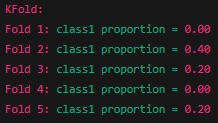
        
        - If `StratifiedKFold` with 5 folds is used, the crated folds may look as follows, where you notice that each fold preserves the same class proportion as the original dataset (i.e. 10% of class 1).
        
            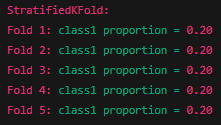
    - Final note:
        - We only need to use `StratifiedKFold` function when dealing with classification problem. When dealing with regression problems, we can just use `KFold` as there are no class labels to stratify.
        - When dealing with time-series prediction (regardless whether regression or classifcation), we use `TimeSeriesSplit` to preserve chronological order.
        
        
- `cross_val_predict`
    - It is used to get cross-validated predictions for each fold.
    - The step-by-step process under the hood is as follows,
        1. Split the data into K folds.
        2. For each fold: (i) Train on (K-1) folds, then (ii) predict on the remining fold
        3. Stitch all out-of-fold predictions together, so there is a prediciton on each row of your dataset
    - Notable parameters of the function,
        - `cv`: It controls how the folds are created, e.g. you could use `KFold`, `StratifiedKFold`, `TimeSeriesSplit`, etc.
        - `method`: 
            - 'predict' → returns class labels (for classification problem) or regression values (for regression problem).
            - 'predict_proba' → returns class probabilities (for classification problem).

- `precision_recall_curve`
    - It copmutes precision and recall for every possible decision threshold from 0 -> 1. Therefore, it helps to fascilitate finding the best thershold

In [147]:
class ThresholdTunedClassifier():
    """
    A meta-estimator that:
      1) tunes hyperparameters via inner CV (RandomizedSearchCV, scoring=AP by default),
      2) produces OOF probabilities via outer CV,
      3) (optionally) learns a calibration mapping on OOF probs (isotonic or Platt),
      4) selects the F1-optimal decision threshold on (calibrated or raw) OOF probs,
      5) refits the best model on the full training set, and
      6) predicts with the frozen threshold.
    """

    def __init__(
        self,
        base_estimator,
        random_state=123,
        n_jobs=-1,
        verbose=0,
    ):
        self.base_estimator = base_estimator
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose

        # Learned attributes after fit()/tuning
        self.best_estimator_ = None
        self.calibrator_ = None
        self.use_calibration_ = False
        self.threshold_ = 0.5

    # ------------ helpers ------------

    @staticmethod
    def _max_f1_threshold(y_true, y_proba):
        """
        Find decision threshold that maximizes F1.

        Note: precision_recall_curve returns precision/recall length (n_thr+1),
        thresholds length (n_thr). Align F1 to thresholds using f1[:-1].
        """
        prec, rec, thr = precision_recall_curve(y_true, y_proba)
        f1 = 2 * prec * rec / (prec + rec + 1e-12)

        if thr.size == 0:
            # degenerate case (e.g., constant scores); fall back to 0.5
            return 0.5, float(f1_score(y_true, (y_proba >= 0.5).astype(int)))

        idx = int(np.nanargmax(f1[:-1]))     # align with thresholds
        optimal_thr = float(thr[idx])
        optimal_f1  = float(f1[:-1][idx])
        return optimal_thr, optimal_f1

    def _fit_calibrator(self, y_proba, y_true):
        """
        Fit probability calibrator (isotonic or Platt).
        """
        if self.calibration_method == "isotonic":
            iso = IsotonicRegression(out_of_bounds="clip")
            iso.fit(y_proba, y_true)
            return iso
        elif self.calibration_method == "platt":
            lr = LogisticRegression(solver="lbfgs", max_iter=1000)
            lr.fit(y_proba.reshape(-1, 1), y_true)  # requires 2D
            return lr
        else:
            raise ValueError("calibration_method must be 'isotonic' or 'platt'")

    def _apply_calibrator(self, calibrator, y_proba):
        """
        Apply fitted calibrator to raw probabilities.
        """
        if calibrator is None:
            return y_proba
        if isinstance(calibrator, IsotonicRegression):
            return calibrator.transform(y_proba)
        elif isinstance(calibrator, LogisticRegression):
            return calibrator.predict_proba(y_proba.reshape(-1, 1))[:, 1]
        else:
            raise TypeError("Unknown calibrator type")

    # ------------ core API ------------

    def model_tuning(self, X, y, param_distributions, n_iter=1, n_folds=3, tuner_scoring="average_precision"):
        """
        Inner-CV hyperparameter tuning. Sets self.best_estimator_ and returns it.
        """
        self.param_distributions = param_distributions
        self.n_iter = n_iter
        self.tuner_scoring = tuner_scoring

        cv = StratifiedKFold(
            n_splits=n_folds, shuffle=True, random_state=self.random_state
        )

        tuner = RandomizedSearchCV(
            estimator=self.base_estimator,
            param_distributions=self.param_distributions,
            n_iter=self.n_iter,
            scoring=self.tuner_scoring,
            cv=cv,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
            verbose=self.verbose,
            refit=True,
        )
        tuner.fit(X, y)
        self.best_estimator_ = tuner.best_estimator_
        return self.best_estimator_
    
    def enter_best_model_config(self, best_model):
        """
        Manually define the hyper-parameter configuration for the best model
        """
        self.best_estimator_ = best_model
        return self.best_estimator_
    
    def decision_thr_tuning(self, X, y, n_folds=3):
        """
        Build OOF probabilities (using OUTER CV), compute F1-opt threshold,
        and return (oof_proba, thr_raw, f1_raw).
        """
        cv = StratifiedKFold(
            n_splits=n_folds, shuffle=True, random_state=self.random_state
        )

        oof_proba = cross_val_predict(
            self.best_estimator_, X, y, cv=cv, method="predict_proba", n_jobs=self.n_jobs
        )[:, 1]

        thr_raw, f1_raw = self._max_f1_threshold(y, oof_proba)
        self.threshold_ = thr_raw
        return oof_proba, thr_raw, f1_raw

    def calibrate_prob(self, y, oof_proba, thr_raw, f1_raw, calibration_method="isotonic"):
        """
        Calibration learned on OOF probs.
        """
        self.calibration_method = calibration_method

        calibrator = self._fit_calibrator(oof_proba, y)
        oof_proba_cal = self._apply_calibrator(calibrator, oof_proba)
        thr_cal, f1_cal = self._max_f1_threshold(y, oof_proba_cal)

        use_cal = f1_cal > f1_raw

        if use_cal:
            self.use_calibration_ = True
            self.calibrator_ = calibrator
            self.threshold_ = thr_cal
        else:
            self.use_calibration_ = False
            self.calibrator_ = None
            self.threshold_ = thr_raw

        return self.threshold_

    def model_training(self, X, y):
        if self.best_estimator_ is None:
            raise RuntimeError("Call model_tuning() before model_training().")
        self.best_estimator_.fit(X, y)

    def analyze_performance(self, X, y, n_folds):
        # Compute OOF probabilities
        cv = StratifiedKFold(
            n_splits=n_folds, shuffle=True, random_state=self.random_state
        )
        y_proba_pred = cross_val_predict(
            self.best_estimator_, X, y, cv=cv, method="predict_proba", n_jobs=self.n_jobs
        )[:, 1]
        
        # Apply calibration (if enabled)
        if self.use_calibration_:
            y_proba_eval = self._apply_calibrator(self.calibrator, y_proba_pred)
        else:
            y_proba_eval = y_proba_pred
        y_proba_eval = np.clip(y_proba_eval, 0.0, 1.0)
        
        # Metrics independent on Decision Threshold
        roc_auc = roc_auc_score(y, y_proba_pred)
        average_precision = average_precision_score(y, y_proba_pred)
        
        # Metrics dependent on Decision Threshold
        y_pred = (y_proba_eval >= self.threshold_).astype(int)
        f1_pos = f1_score(y, y_pred, pos_label=1, average="binary")  # class 1
        f1_neg = f1_score(y, y_pred, pos_label=0, average="binary")  # class 0
        f1_macro = f1_score(y, y_pred, average="macro")
        
        results = {
            "roc_auc": float(roc_auc),
            "average_precision": float(average_precision),
            "f1_class_1": float(f1_pos),
            "f1_class_0": float(f1_neg),
            "f1_macro": float(f1_macro),
        }
        self.last_cv_metrics_ = results
        
        return results
    
    def predict_proba(self, X):
        """
        Predict class probabilities; applies calibration if enabled.
        Returns shape (n_samples, 2) = [P(class 0), P(class 1)].
        """
        if self.best_estimator_ is None:
            raise RuntimeError("Call model_training() before predict_proba().")
        proba = self.best_estimator_.predict_proba(X)[:, 1]
        if self.use_calibration_:
            proba = self._apply_calibrator(self.calibrator_, proba)
        proba = np.clip(proba, 0.0, 1.0)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        """
        Thresholded class prediction using self.threshold_.
        """
        p = self.predict_proba(X)[:, 1]
        return (p >= self.threshold_).astype(int)

## Linear Regression

In [137]:
# Define the base model
logit_base = LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", random_state=123)
logit = ThresholdTunedClassifier(logit_base)

# Perform hyperparamater tuning
logit_param_grid = {"C": np.logspace(-3, 3, 13), "penalty": ["l1", "l2"]}
logit.model_tuning(X_train, y_train, logit_param_grid, n_iter=1, n_folds=3, tuner_scoring="average_precision")

LogisticRegression(C=316.22776601683796, class_weight='balanced', max_iter=1000,
                   penalty='l1', random_state=123, solver='saga')

In [140]:
# Tune Decision Threshold
logit_oof_proba, logit_thr_raw, logit_f1_raw = logit.decision_thr_tuning(X_train, y_train, n_folds=5)

In [141]:
# Calibrate the model
logit_thr_cal = logit.calibrate_prob(y_train, logit_oof_proba, logit_thr_raw, logit_f1_raw, calibration_method='isotonic')

In [142]:
# Train the optimal model with the best set of hyper-parameters
logit.model_training(X_train, y_train)

In [149]:
# Analyze model performance
logit.analyze_performance(X_train, y_train, n_folds=5)

{'roc_auc': 0.8939779992654119,
 'average_precision': 0.6665519214208623,
 'f1_class_1': 0.6173343744369031,
 'f1_class_0': 0.9366957800498803,
 'f1_macro': 0.7770150772433917}

## Optuna Hyper-parmaeter tuning

This section is just to explain how to apply Optuna hyper-parameter tuning, which will be employed later for the ML models.

`optuna` library:

- How to define the hyper-parameter space in `optuna`?

    We do so by calling the following methods,
    - `suggest_categorical(name, choices)`: Optuna will chose one value from a discrete list (non-numeric)
        - `trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])`
                
    - `suggest_float(name, low, high, *, step=None, log=False)`: Sample a real (floating-point) number from `[low, high]`
        - If `step` is given, values are multiples of step.
        
            `trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)`
        
        - If `log=True`: samples log-uniformly, i.e. values are spread multiplicatively.
        
            `trial.suggest_float("momentum", 0.0, 1.0, step=0.1)`
        
    - `suggest_int(name, low, high, step=1, log=False)`: Sample an integer value
        - `batch_size = trial.suggest_int("batch_size", 32, 256, step=32, log=True)`

In [ ]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": "saga",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 123
    }
    
    model = LogisticRegression(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="average_precision", n_jobs=-1)
    
    return scores.mean()


# Perform hyper-parameter optimization
study = optuna.create_study(
    direction = "maximize",
    sampler = optuna.samplers.TPESampler(seed=2025)
)
study.optimize(objective, n_trials=5)

print("Best AP:", study.best_value)
print("Best params:", study.best_params)

How to apply pruning in `Optuna`?

There are many places to place pruning. Here are some examples, and how pruning is applied, (Note: A "Trial" here refers to a randomly selected set of hyper-parameters)
    
1. **Fold-based pruning**

    ```python
    def objective(trial):
        params = {
            "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
            "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
            "solver": "saga",
            "max_iter": 2000,
            "class_weight": "balanced",
            "random_state": 123
        }

        model = LogisticRegression(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)

        scores = []
        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
            # train on the fold and compute pefromance
            model.fit(X_train[train_idx], y_train[train_idx])
            proba = model.predict_proba(X_train[val_idx])[:, 1]
            ap = average_precision_score(y_train[val_idx], proba)
            scores.append(ap)

            # report performance
            trial.report(float(np.mean(scores)), step=fold_idx)

            # check for pruning
            if trial.should_prune():
                raise optuna.TrialPruned()

        return scores.mean()

    # Define the pruner
    pruner = optuna.pruners.SuccessiveHalvingPruner(
        min_resource=1,          # start checking at first fold
        reduction_factor=3,      # roughly keep top 1/3 at each rung
        min_early_stopping_rate=0
    )

    # Perform hyper-parameter optimization
    study = optuna.create_study(
        direction = "maximize",
        sampler = optuna.samplers.TPESampler(seed=2025),
        pruner = pruner
    )
    study.optimize(objective, n_trials=5)

    print("Best AP:", study.best_value)
    print("Best params:", study.best_params)
    ```

    - In general, for a given trial, we would run 5-fold CV. At each fold,
        - The average precision is computed and then reported to Optuna `trial.report(np.mean(scores), step=k)`.
        - Then we ask Optuna on whether to prune or not `trial.should_prune()`.

    - How does the pruner acts here?
        - In the example below, the pruner used is: `SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0)`
        - It defines "rungs" (checkpoints): `r = min_resource * (reduction_factor)^i = 1, 3, 9, …`
        - In your loop, `step = fold_index`, so: It can prune after fold 1 (rung 1) and after fold 3 (rung 3); while Folds 2, 4, 5 are not pruning decision points for SHA (you still report; it just won’t perform pruning there).
        - At each rung, the pruner compares your trial’s running mean AP at that step to the leaderboard of past trials at the same rung:
            - Rung 1 (after fold 1): keep roughly the top 1/3 of trials seen so far; prune the rest.
            - Rung 3 (after fold 3): among trials that reached fold 3, keep again the top 1/3; prune the rest.
            - There’s no rung at 5, so if you reach fold 4/5, you’ll finish the trial.

    - What happens if a trial gets pruned?
        - When `trial.should_prune()` returns `True`, your objective raises `optuna.TrialPruned()`. That immediately stops the current trial: the loop breaks, the current fold (or epoch) ends, and no further folds/epochs are run. Optuna will then go to the next trial.
        - Note that Optuna still uses the intermediate values that you have previously reported in the current trial via `trial.report(value, step)` to help guide future hyper-parameter set sampling.






2. **Epoch/Boosting-round based pruning**

    ```python
    from optuna.integration import XGBoostPruningCallback

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 3000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "eval_metric": "aucpr",
            "random_state": 123,
            "n_jobs": -1,
            "tree_method": "hist",
        }
        base = XGBClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
        scores = []

        for tr, va in cv.split(X_train, y_train):
            model = clone(base)
            pruning_cb = XGBoostPruningCallback(trial, "validation_0-aucpr")  # sklearn API name
            model.fit(
                X_train[tr], y_train[tr],
                eval_set=[(X_train[va], y_train[va])],
                callbacks=[pruning_cb],          # pruning each boosting round
                verbose=False
            )
            proba = model.predict_proba(X_train[va])[:, 1]
            scores.append(average_precision_score(y_train[va], proba))

        return float(np.mean(scores))

    # Define the pruner
    pruner = optuna.pruners.SuccessiveHalvingPruner(
        min_resource=1,          # start checking at first fold
        reduction_factor=3,      # roughly keep top 1/3 at each rung
        min_early_stopping_rate=0
    )

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=2025, n_startup_trials=20),
        pruner=pruner
    )

    study.optimize(objective, n_trials=200)

    print("Best AP:", study.best_value)
    print("Best params:", study.best_params)
    ```

    - This type of pruning is performed during the training of the model itself. It is more granular than fold-based pruning.
        - In fold-based pruning, the pruning happens between folds only (i.e. after fit finishes on each fold)
        - In Epoch/Boosting-round based pruning, pruning happens per bossting round inside a single training run.
    - Since this happens within a training round, we would need to use a callback that is intergrated into the model,
        - XGBoost: `from optuna.integration import XGBoostPruningCallback`
        - LightGBM: `from optuna.integration import LightGBMPruningCallback`
        - CatBoost: `from optuna.integration import CatBoostPruningCallback`
        - Tesorflow + Keras: `from optuna_integration import TFKerasPruningCallback`
        - Pytorch: There is one.
        - SkLearn: Apparently there is none, i.e. we cannot perform this if we are using model from SkLearn lirabry. -> Double check this
    - Since we are using the built in callback `XGBoostPruningCallback`, under the hood, it will automatically call `trial.report` and `if trial.should_prune(): raise TrialPruned()` at each boosting round.
    - What does "validation_0-aucpr" represent?

        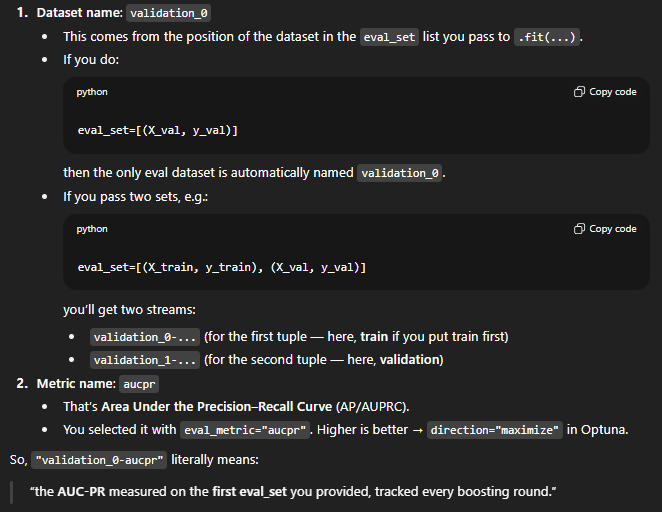

    - Is the performance of the current fold in the current trial compared with the performance of the previous trials in the same fold and the same boosting round?
        - Same boosting round? Yes.
        - Same fold? No — fold isn’t part of the comparison key. Fold is invisible to the pruner: it doesn’t know (or care) whether the number came from fold 1 or fold 4. Only the step index (round) matters.

#### Fold-based pruning

In [ ]:
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": "saga",
        "max_iter": 2000,
        "class_weight": "balanced",
        "random_state": 123
    }
    
    model = LogisticRegression(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
    
    scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
        # train on the fold and compute pefromance
        model.fit(X_train[train_idx], y_train[train_idx])
        proba = model.predict_proba(X_train[val_idx])[:, 1]
        ap = average_precision_score(y_train[val_idx], proba)
        scores.append(ap)
        
        # report performance
        trial.report(float(np.mean(scores)), step=fold_idx)
        
        # check for pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return scores.mean()


# Define the pruner
pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=1,          # start checking at first fold
    reduction_factor=3,      # roughly keep top 1/3 at each rung
    min_early_stopping_rate=0
)

# Perform hyper-parameter optimization
study = optuna.create_study(
    direction = "maximize",
    sampler = optuna.samplers.TPESampler(seed=2025),
    pruner = pruner
)
study.optimize(objective, n_trials=5)

print("Best AP:", study.best_value)
print("Best params:", study.best_params)

#### Epoch/Boosting-round based pruning

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 3000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "eval_metric": "aucpr",
        "random_state": 123,
        "n_jobs": -1,
        "tree_method": "hist",
    }
    base = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
    scores = []

    for tr, va in cv.split(X_train, y_train):
        model = clone(base)
        pruning_cb = XGBoostPruningCallback(trial, "validation_0-aucpr")  # sklearn API name
        model.fit(
            X_train[tr], y_train[tr],
            eval_set=[(X_train[va], y_train[va])],
            callbacks=[pruning_cb],          # pruning each boosting round
            verbose=False
        )
        proba = model.predict_proba(X_train[va])[:, 1]
        scores.append(average_precision_score(y_train[va], proba))

    return float(np.mean(scores))

# Define the pruner
pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=1,          # start checking at first fold
    reduction_factor=3,      # roughly keep top 1/3 at each rung
    min_early_stopping_rate=0
)

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2025, n_startup_trials=20),
    pruner=pruner
)

study.optimize(objective, n_trials=200)

print("Best AP:", study.best_value)
print("Best params:", study.best_params)

## XGBoost

Hyperparameters in `XGBClassifier` function,
- `n_estimators`
    - It represents the number of trees contructed, i.e. the number of boosting rounds.
    - Too low → underfitting; too high → overfitting (unless you use early stopping).
- `learning_rate`
    - It represents the learning rate in the gradient descent equation.
    - Lower values make training slower but often more accurate.
- `max_depth`
    - It controls the maximum depth of a tree.
    - Higher values increase complexity and risk overfitting.
- `min_child_weight`
    - It refers to "cover", i.e. the sum of the Hessian in a node, which is used in the denominator of the Similarity Score computation
    - And so the 'min_child_weight' hyper-parameter sets a lower bound on this quantity when growing a tree. The idea is that small "cover" indicates that the node has too few or weakly influential samples, and therefore, XGBoost should avoid spliting the node, preventing overfitting

- `gamma`
    - This hyper-parameter is used for pruning. It represents the minimum required gain to make a split at a tree node.
    - If the gain < gamma, the split is pruned.
- `subsample`
    - Fraction of training samples used per tree, useful to prevent overfitting.
- `colsample_bytree`
    - Fraction of features sampled per tree
- `colsample_bylevel`
    - Fraction of features sampled per split
- `reg_lambda`
    - It controls the strenght of the L2 regularization
- `reg_alpha`
    - It controls the strenght of the L1 regularization

In [177]:
def xgb_objective(trial):
    # define model hyper-parameters and hyper-parameter search space
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() # From XGBoost documentation: the weight should be the ratio between the negative class and postiive class, not the other way around
    params = {
        "objective": 'binary:logistic',
        "eval_metric": ["aucpr"], # This has to be defined, because this is the metric that will be used during pruning
        "random_state": 98464,
        "scale_pos_weight": scale_pos_weight,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 32.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.7, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e+1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e+1, log=True)
    }
    
    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        pruning_cb = XGBoostPruningCallback(trial, "validation_0-aucpr") # Boosting-round based pruning
        model.fit(
            X_train.iloc[train_idx,:], y_train.iloc[train_idx],
            eval_set=[(X_train.iloc[val_idx,:], y_train.iloc[val_idx])],
            callbacks=[pruning_cb],          # pruning each boosting round
            verbose=False
        )
        proba = model.predict_proba(X_train.iloc[val_idx,:])[:, 1]
        scores.append(average_precision_score(y_train.iloc[val_idx], proba))

    return float(np.mean(scores))

# Define the pruner
pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=1,          # start checking at first fold
    reduction_factor=3,      # roughly keep top 1/3 at each rung
    min_early_stopping_rate=0
)

xgb_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=2025, n_startup_trials=20),
    pruner=pruner
)

xgb_study.optimize(xgb_objective, n_trials=25)

[I 2025-10-17 16:35:57,540] A new study created in memory with name: no-name-ced42d91-5101-432c-b82c-c6c0844c1195
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\optuna\trial\_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\optuna\trial\_trial.py:5

In [180]:
print("Best AP:", xgb_study.best_value)
print("Best params:", xgb_study.best_params)

Best AP: 0.8691217027889813
Best params: {'learning_rate': 0.04567797641354878, 'n_estimators': 700, 'max_depth': 10, 'min_child_weight': 1.487591328040063, 'gamma': 0.6148438796556545, 'subsample': 0.6555440242036668, 'colsample_bytree': 0.9546175048343338, 'colsample_bynode': 0.9981328231697334, 'reg_lambda': 4.516408218824092, 'reg_alpha': 1.3390046097540015e-06}


In [ ]:
# Define the optimized model
enter_best_model_config(self, XGBClassifier(**xgb_study.best_params))

In [ ]:
# Define the base model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() # From XGBoost documentation: the weight should be the ratio between the negative class and postiive class, not the other way around
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=123,
    scale_pos_weight=scale_pos_weight,
)
xgb = ThresholdTunedClassifier(xgb_base)

# Perform hyperparamater tuning
xgb_param_grid = {
    "learning_rate":    [0.03, 0.05, 0.07, 0.1],
    "n_estimators":     [300, 500, 800],
    "max_depth":        [3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 4, 8, 16],
    "gamma":            [0, 0.05, 0.1, 0.2, 0.5],
    "subsample":        [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "colsample_bynode": [0.7, 0.9, 1.0],
    "reg_lambda":       [0.0, 0.5, 1.0, 2.0, 5.0],
    "reg_alpha":        [0.0, 0.1, 0.5, 1.0, 2.0],
}
xgb.model_tuning(X_train, y_train, xgb_param_grid, n_iter=1, n_folds=3, tuner_scoring="average_precision")

In [ ]:
# Tune Decision Threshold
xgb_oof_proba, xgb_thr_raw, xgb_f1_raw = xgb.decision_thr_tuning(X_train, y_train, n_folds=5)

In [ ]:
# Calibrate the model
xgb_thr_cal = xgb.calibrate_prob(y_train, xgb_oof_proba, xgb_thr_raw, xgb_f1_raw, calibration_method='isotonic')

In [ ]:
# Train the optimal model with the best set of hyper-parameters
xgb.model_training(X_train, y_train)

In [ ]:
# Analyze model performance
xgb.analyze_performance(X_train, y_train, n_folds=5)

## LightGBM

**Hyperparameters in `LGBMClassifier` function**

Parameters related to preventing overfitting:
- `n_estimators`
    - Number of boosting rounds (trees).    
- `num_leaves`
    - Maximum number of leaf nodes per tree.
- `max_depth`
    - Maximum depth per tree.
- `feature_fraction`
    - Fraction of features (randomly sampled) used per tree.
- `feature_fraction_bynode `
    - Fraction of features on each tree node.
    - For example, if you set it to 0.8, LightGBM will select 80% of features at each tree node.
    - If both feature_fraction and feature_fraction_bynode are smaller than 1.0, the final fraction of each node is feature_fraction * feature_fraction_bynode
- `min_child_samples`
    - Minimum number of samples required to form a new leaf.
- `min_sum_hessian_in_leaf`
    - Minimum total “Hessian” (second derivative of the loss) required to form a new leaf.
    - Note: The idea is the same as the "min_child_weight" parameter in XGBoost.
- `min_split_gain`
    - Minimum “gain” (reduction in loss) required to make another split.
- `lambda_l1` and `lambda_l2`
    - L1 (lasso) and L2 (ridge) regularization terms on leaf weights (i.e. the leaf output values).

Parameters related to boosting type:
- `boosting_type`
    
    There are 2 main types of boosting that can be chosen
    - `gbdt` -> This is the default boosting type
        - This is the standard Gradient Boosted Decision Tree (GBDT).
        - These are the relvant parameters when GBDT is selected as the boosting type:
            - `subsample` or `bagging_fraction`
                - Fraction of rows (randomly sampled) used per tree.
            - `bagging_freq`
                - How often LightGBM performs the `subsample` / bagging
                - 0 -> subsampling is disabled (default); 1 -> Subsample a new random subset of rows for every tree; 5 -> Subsamble a new subset every 5 trees.
    - `goss`
        - This is the Gradient-based One-Sided-Sampling (GOSS).
        - These are the relvant parameters when GOSS is selected as the boosting type:
            - `top_rate`
                - fraction (0–1) of data points with the largest gradients that are always kept
            - `other_rate`
                - fraction (0–1) of the remaining points (small gradients) that are randomly sampled
        
Parameters related to Histogram-based splitting:
- `max_bin`
    - Max number of discrete bins per feature.
- `min_data_in_bin`
    - Minimum number of samples required to keep a bin. Helps avoid tiny, noisy bins.


Parameters related to Exclusive Feature Bundling (EFB):
- `enable_bundle` -> Default = True
    - Turns EFB on (True) / off (False)
- `max_conflict_rate`
    - Allows a small fraction of overlap (“conflict”) between features that are bundled.
    - If set to 0.0, only bundle features that never have non-zeros at the same rows.

Parameters related to early stopping:
- `early_stopping_rounds`
    - Stop if the monitored metric doesn’t improve for this many consecutive boosting rounds.
- `eval_set`
    - List of validation tuples; the first tuple is monitored for early stopping.
- `eval_metric`
    - Metric name(s) (e.g., "binary_logloss", "auc", "average_precision"). If multiple metrics are given, all are logged; early stopping uses the first metric unless you change callback behavior.
    
Misc parameters:
- `learning_rate`
    - It represents the learning rate in the gradient descent equation.

In [ ]:
# Define the base model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() # From XGBoost documentation: the weight should be the ratio between the negative class and postiive class, not the other way around
lgbm_base = LGBMClassifier(
    objective="binary",
    boosting_type='gbdt', # 'gbdt' for Gradient Boosted Decision Tree or 'goss' for Gradient-based One-Sided-Sampling
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)
lgbm = ThresholdTunedClassifier(lgbm_base)

# Perform hyperparamater tuning
lgbm_param_grid = {
    "learning_rate":            [0.03, 0.05, 0.07],
    "n_estimators":             [300, 500, 800],
    "num_leaves":               [31, 63, 95, 127, 191],
    "max_depth":                [-1, 6, 8, 10],
    "min_child_samples":        [20, 40, 60, 80, 120],
    "min_sum_hessian_in_leaf":  [1e-3, 1e-2, 1e-1, 1, 5],
    "min_split_gain":           [0.0, 0.05, 0.1, 0.2],
    "lambda_l2":                [0.0, 0.5, 1.0, 2.0, 5.0],
    "lambda_l1":                [0.0, 0.1, 0.5, 1.0, 2.0],
    "feature_fraction":         [0.7, 0.8, 0.9, 1.0],
    "feature_fraction_bynode":  [0.7, 0.85, 1.0],
    "subsample":                [0.7, 0.85, 1.0],
    "bagging_freq":             [0, 1],     # 0 disables row sampling; 1 bags each tree
    "max_bin":                  [63, 127, 255],
    # If GOSS is used, rather than GBDT as the boosting_type
    # "top_rate":        [0.1, 0.2, 0.3],
    # "other_rate":      [0.05, 0.1, 0.2],
}

lgbm.model_tuning(X_train, y_train, lgbm_param_grid, n_iter=1, n_folds=3, tuner_scoring="average_precision")

In [ ]:
# Tune Decision Threshold
lgbm_oof_proba, lgbm_thr_raw, lgbm_f1_raw = lgbm.decision_thr_tuning(lgbm.best_estimator_, X_train, y_train, n_folds=5)

In [ ]:
# Calibrate the model
lgbm_thr_cal = lgbm.calibrate_prob(y_train, lgbm_oof_proba, lgbm_thr_raw, lgbm_f1_raw, calibration_method='isotonic')

In [ ]:
# Train the optimal model with the best set of hyper-parameters
lgbm.model_training(X_train, y_train)

In [ ]:
# Analyze model performance
lgbm.analyze_performance(X_train, y_train, n_folds=5)

## CatBoost

**Hyperparameters in `CatBoostClassifier` function**

Hyperparameters related to learning
- `iterations`
    - The number of boosting rounds (i.e. how many trees to build).
- `learning_rate`
    - It represents the learning rate in the gradient descent equation.
- `depth`
    - Tree depth (CatBoost uses symmetric trees by default).
- `l2_leaf_reg`
    - L2 regularization on leaf output values.
    
Hyperparameters related to stochasticity
- `random_strength`
    - When selecting the best feature for a split in a tree node, the feature that generates the largest Gain is selected. This Gain has no randomness. So, this hyperparameter is used to add a normally disctributed random vairable (with zero mean and variance that decreases during the training time) to the Gain score of the feature. Therefore, it helps to aboid overfitting.
- `bootstrap_type`
    - It controls how CatBoost samples rows for each tree, i.e. in Bootstrapping.
    - Keep it at its defaul value "Bayesian" -> Do not bother tuning this.
    - What is Bayesian Bootstrap?
        
        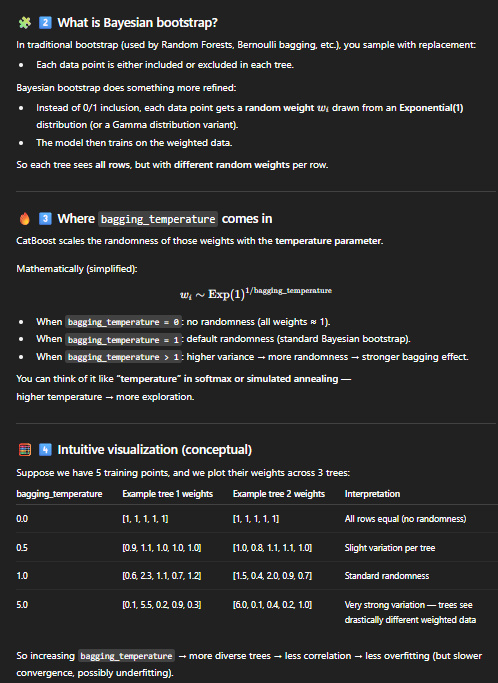
- `bagging_temperature`
    - Controls Bayesian bootstrap aggressiveness (higher = more stochastic). Useful when we have set  `bootstrap_type='Bayesian'`, as explained in the above bullet point.
- `colsample_bylevel` / `rsm`
    - Fraction of features (columns) are randomly selected for each tree level.

Hyperparameters realted to tree grwoth policy
- `grow_policy`
    - You can choose between `SymmetricTree` (default), `Depthwise`, or `Lossguide` (leafwise)
    - The last two unlock extra hyperparameters:
        - `min_data_in_leaf`: Minimum number of samples that must land in a leaf for that leaf to be created. This prevents leaves contining too little data, leading to overfitting.
        - `max_leaves`: Maximum number of leaves in a tree for `Lossguide` (leafwise)

Hyperparameters related to handling numerical features
- `border_count` / `max_bin`
    - Number of bins uesd to discretize numerical features before splitting, i.e. histogram-based splitting.
    
Hyperparameters related to categorical features
- `one_hot_max_size`
     - For a given categorical feature, CatBoost counts how many unique categories it has in the training data. Then,
         - If the count ≤ `one_hot_max_size`, CatBoost one-hot encodes that feature.
         - If the count > `one_hot_max_size`, CatBoost does not one-hot; it uses its native Ordered CTR / Ordered Target Statistics for that feature.
- Hyperparameters that controls Ordered Target Statistics / Ordered CTR
    - `max_ctr_complexity`
        - The max size of categorical feature combinations used to build combination CTRs, i.e. for Ordered Combo CTR.
        - Keep it small (often 1–2) unless you have few categorical features and plenty of data.
    - `ctr_target_border_count`
        - The number of borders when performing Ordered CTR.
        - This is most important to tune in regression problem. This is irrelevant in classification task (both binary and multi-class).

In [ ]:
# Use pre-transformed categorical features (e.g. categorical features not encoded)
X_train_catb = df_train.copy().drop('loan_status', axis=1)
X_test_catb = df_test.copy()

In [ ]:
# Identify categorical columns (i.e. of type "object" or "category")
cat_cols = X_train_catb.select_dtypes(include=['object', 'category']).columns.to_list()
cat_idx = [X_train_catb.columns.get_loc(col) for col in cat_cols]

In [ ]:
# Define the base model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = {0: 1.0, 1: scale_pos_weight}

catb_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',           # Precision-Recall AUC
    grow_policy='SymmetricTree',    # Default
    bootstrap_type='Bayesian',     # default, works with bagging_temperature
    cat_features=cat_idx,          # list of categorical column indices
    random_seed=42,
    class_weights=class_weights
)
catb = ThresholdTunedClassifier(catb_base)

# Perform hyperparamater tuning
catb_param_grid = {
    # 'iterations': [300, 500, 800],
    'iterations': [500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'random_strength': [0, 0.5, 1.0, 2.0],
    'bagging_temperature': [0.5, 1.0, 2.0],   # for Bayesian bootstrap
    'colsample_bylevel': [0.8, 1.0],
    'border_count': [128, 254],
    'one_hot_max_size': [2, 5, 7],           # threshold for OHE vs Ordered CTR
    'max_ctr_complexity': [1, 2]              # Ordered Combo CTR depth
}

catb.model_tuning(X_train_catb, y_train, catb_param_grid, n_iter=1, n_folds=3, tuner_scoring="average_precision")

In [ ]:
# Tune Decision Threshold
catb_oof_proba, catb_thr_raw, catb_f1_raw = catb.decision_thr_tuning(catb.best_estimator_, X_train_catb, y_train, n_folds=5)

In [ ]:
# Calibrate the model
catb_thr_cal = catb.calibrate_prob(y_train, catb_oof_proba, catb_thr_raw, catb_f1_raw, calibration_method='isotonic')

In [ ]:
# Train the optimal model with the best set of hyper-parameters
catb.model_training(X_train_catb, y_train)

In [ ]:
# Analyze model performance
catb.analyze_performance(X_train_catb, y_train, n_folds=5)

- Do I perform one-hot-encoding on the Categorical features? Or should I just leave them as it is?
- Do CatBoost treat ordinal and nominal categorical features the same way?
- Apply class weights during training

# Stacking
- Train a meta model on the prob predictions of each of the methods

## Misc

In [ ]:
mini_size = 1000
mini_X_train = X_train.copy().iloc[:mini_size,:]
mini_y_train = y_train.copy().iloc[:mini_size]

In [ ]:
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength':0,
    'l2_leaf_reg': 0.7047064221215757,
    'random_seed':42,
    'verbose':False    
}

model = CatBoostClassifier(cat_features=cat_idx, **catboost_params)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
oof_proba = cross_val_predict(
    model, X_train_catb, y_train, cv=outer, method="predict_proba"
)[:, 1]

In [ ]:
average_precision_score(y_train, oof_proba)

In [ ]:
catboost_params = {'iterations': 500,
 'learning_rate': 0.05,
 'depth': 4,
 'l2_leaf_reg': 10,
 'loss_function': 'Logloss',
 'border_count': 254,
 'random_seed': 42,
 'max_ctr_complexity': 1,
 'class_weights': {0: 1.0, 1: 6.023353293413174},
 'one_hot_max_size': 2,
 'random_strength': 2.0,
 'eval_metric': 'PRAUC',
 'bagging_temperature': 0.5,
 'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.8,
 'grow_policy': 'SymmetricTree'}

model = CatBoostClassifier(cat_features=cat_idx, **catboost_params)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
oof_proba = cross_val_predict(
    model, X_train_catb, y_train, cv=outer, method="predict_proba"
)[:, 1]

In [ ]:
average_precision_score(y_train, oof_proba)

In [ ]:
roc_auc_score(y_train, oof_proba)